In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv


--2023-10-09 21:45:00--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘data.csv.3’

data.csv.3          100%[===================>]   1,41M  2,19MB/s    in 0,6s    

2023-10-09 21:45:01 (2,19 MB/s) - ‘data.csv.3’ saved [1475504/1475504]



In [3]:
df = pd.read_csv("data.csv")
df=df[["Make",
"Model",
"Year",
"Engine HP",
"Engine Cylinders",
"Transmission Type",
"Vehicle Style",
"highway MPG",
"city mpg",
"MSRP"]]

In [4]:
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [5]:
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [6]:
df = df.fillna(0)

In [7]:
threshold = df["msrp"].mean()
df["above_average"] = df["msrp"].apply(lambda x: 1 if x > threshold else 0)
df = df.drop(columns=["msrp"])

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [9]:
X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

y_train = df_train["above_average"].values
y_val = df_val["above_average"].values
y_test = df_test["above_average"].values

del X_train['above_average']
del X_val['above_average']
del X_test['above_average']

### Q1

In [10]:
numeric_features = df._get_numeric_data().columns
for feature in numeric_features:
    if feature == "above_average":
        continue
    print(feature)
    roc_auc = roc_auc_score(y_train, df_train[feature])
    if roc_auc < 0.5:
        roc_auc = roc_auc_score(y_train, -df_train[feature])

    print(roc_auc)    


year
0.687551492804683
engine_hp
0.9171031265539011
engine_cylinders
0.766116490165669
highway_mpg
0.6330587871772013
city_mpg
0.6734244643245233


### Q2


In [ ]:
X_train

In [12]:
dv = DictVectorizer(sparse=False)

train_dict = X_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [13]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [14]:
pred_val = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, pred_val).round(3)

0.98

### Q3

In [15]:
precision_scores = []
recall_scores = []
thresholds = np.arange(0,1,0.01)
f = np.vectorize(lambda x,t: 1 if x >= t else 0)
for threshold in thresholds:
    pred_classes = f(pred_val, threshold)
    precision_scores.append(precision_score(y_val,pred_classes))
    recall_scores.append(recall_score(y_val,pred_classes))

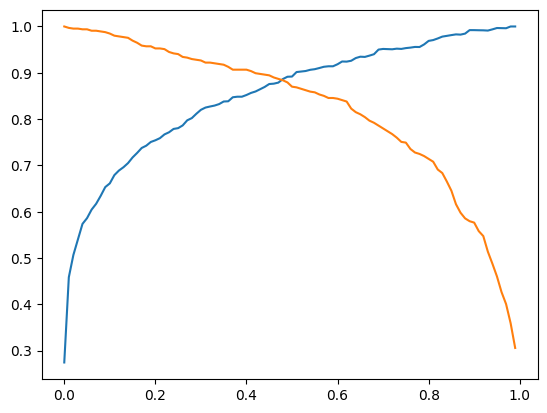

In [16]:
plt.plot(thresholds, precision_scores)
plt.plot(thresholds, recall_scores)

### Q4

In [17]:
thresholds = np.arange(0,1,0.01)
scores = {}
f = np.vectorize(lambda x,t: 1 if x >= t else 0)
for threshold in thresholds:
    pred_classes = f(pred_val, threshold)
    scores[threshold]= f1_score(y_val, pred_classes)

In [18]:
max(scores,key=scores.get)

0.49

### Q5

In [19]:
df_full_train.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'above_average'],
      dtype='object')

In [ ]:
fold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, test_idx in fold.split(df_full_train):
    X_train = df_full_train.iloc[train_idx]
    X_test = df_full_train.iloc[test_idx]
    
    y_train = X_train["above_average"].values
    y_test = X_test["above_average"].values


    del X_train['above_average']
    del X_test['above_average']

    dv = DictVectorizer(sparse=False)

    train_dict = X_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    test_dict = X_test.to_dict(orient='records')
    X_test = dv.transform(test_dict)

    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    proba = model.predict_proba(X_fold_val)
    scores.append(roc_auc_score(y_fold_val, proba))

scores


2 (5718,) (1430,)


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'